In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
datasets.MNIST.resources = [
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
]

In [ ]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

loaders = {
    'train': DataLoader(
        train_data,
        batch_size=100,
        shuffle=True,
        num_workers=1
    ),

    'test': DataLoader(
        test_data,
        batch_size=100,
        shuffle=True,
        num_workers=1
    )
}

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")

def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%\n)")


for epoch in range(1, 11):
    train(epoch)
    test()

Prediction: 2


C:\Users\hyder\AppData\Local\Temp/ipykernel_12280/599564851.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


<function matplotlib.pyplot.show(close=None, block=None)>

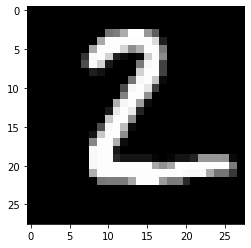

In [112]:
model.eval()

data, target = test_data[1]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f"Prediction: {prediction}")

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')

plt.show

Prediction: 5


C:\Users\hyder\AppData\Local\Temp/ipykernel_12280/599564851.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


<function matplotlib.pyplot.show(close=None, block=None)>

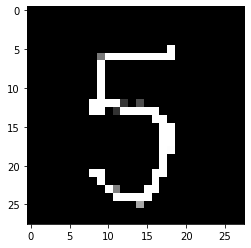

In [130]:
model.eval()

import cv2

img = cv2.imread('Examples/5.png',cv2.IMREAD_GRAYSCALE)  #Read the image as a grayscale
resized = cv2.resize(img, (28,28))  #Resize the data to the MNIST dimensions
features = resized.reshape(1, 28, 28) #Get the image in the form of an array

data = torch.tensor(features)

data = data.unsqueeze(0).to(device)

data = data.float()

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f"Prediction: {prediction}")

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')

plt.show

In [98]:
data.shape

torch.Size([1, 1, 28, 28])